In [ ]:
!pip install vaderSentiment
!pip install transformers
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Acquisition

In [ ]:
#Reading data
dataset = pd.read_csv("/content/twitter_validation.csv")
df = dataset.head(500)
df.head(1)

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...


In [ ]:
df.set_axis(['Id', 'Source', 'Sentiment', 'Text'], axis=1, inplace=True)
df = df.drop(columns = ["Id", "Source"], axis=1)
df = df.rename(columns={'index':'Id'})
df.head()

<ipython-input-49-f33a122f0943>:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis(['Id', 'Source', 'Sentiment', 'Text'], axis=1, inplace=True)


,Sentiment,Text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


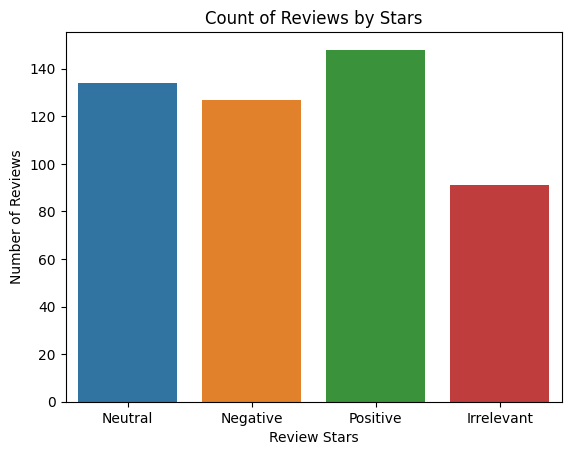

In [ ]:
sns.countplot(df, x='Sentiment')
plt.xlabel("Review Stars")
plt.ylabel("Number of Reviews")
plt.title("Count of Reviews by Stars")
plt.show()

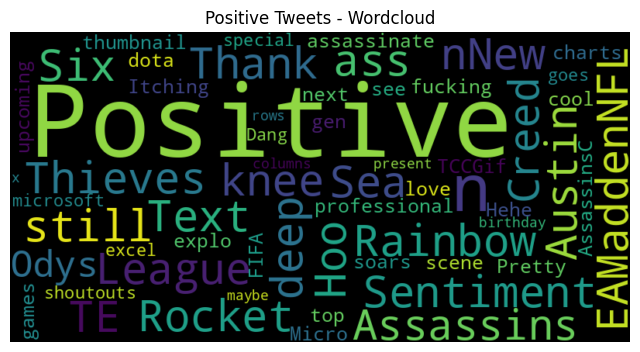

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# Wordcloud with positive tweets
positive_tweets = df[df["Sentiment"] == 'Positive']
stop_words = list(STOPWORDS)
positive_wordcloud = WordCloud(width=800, height=400, background_color="black", stopwords = stop_words).generate(str(positive_tweets))
plt.figure(figsize=[8, 8])
plt.title("Positive Tweets - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

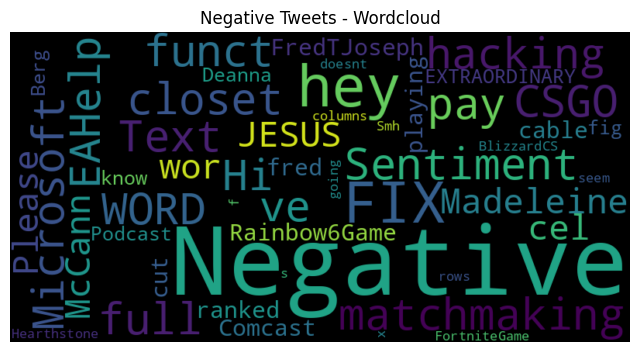

In [ ]:
# Wordcloud with negative tweets
negative_tweets = df[df["Sentiment"] == 'Negative']
stop_words = list(STOPWORDS)
negative_wordcloud = WordCloud(width=800, height=400, background_color="black", stopwords = stop_words).generate(str(negative_tweets))
plt.figure(figsize=[8,8])
plt.title("Negative Tweets - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

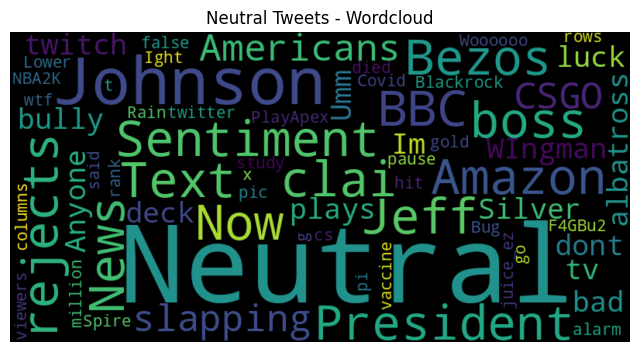

In [ ]:
# Wordcloud with negative tweets
neutral_tweets = df[df["Sentiment"] == 'Neutral']
stop_words = list(STOPWORDS)
neutral_wordcloud = WordCloud(width=800, height=400, background_color="black", stopwords = stop_words).generate(str(neutral_tweets))
plt.figure(figsize=[8, 8])
plt.title("Neutral Tweets - Wordcloud")
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
df = df.replace({"Positive": 1, "Negative": -1, "Neutral":0})
df = df.drop(df[df["Sentiment"]=="Irrelevant"].index, axis=0)
df['Index'] = df.index
df.head()

,Sentiment,Text,Index
0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,0
1,-1,@Microsoft Why do I pay for WORD when it funct...,1
2,-1,"CSGO matchmaking is so full of closet hacking,...",2
3,0,Now the President is slapping Americans in the...,3
4,-1,Hi @EAHelp I’ve had Madeleine McCann in my cel...,4


## Transformer Pipeline

In [ ]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
res = {}
for index, row in df.iterrows():
  try:
    res[index] = sent_pipeline(row["Text"])[0]
  except ValueError:
    pass

In [ ]:
df1 = pd.DataFrame(res).T
df1['Index'] = df1.index
roberta = df.merge(df1, how="left")
roberta.head()

,Sentiment,Text,Index,label,score
0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,0,NEGATIVE,0.990771
1,-1,@Microsoft Why do I pay for WORD when it funct...,1,NEGATIVE,0.999782
2,-1,"CSGO matchmaking is so full of closet hacking,...",2,NEGATIVE,0.999759
3,0,Now the President is slapping Americans in the...,3,NEGATIVE,0.998429
4,-1,Hi @EAHelp I’ve had Madeleine McCann in my cel...,4,NEGATIVE,0.999361


## RoBERTa Pretrained Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from scipy.special import softmax
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
sentence = "This is a very good day to learn some cool coding stuff"
encoded_text = tokenizer(sentence, return_tensors='pt')
output = model(**encoded_text)
scores = softmax(output[0][0].detach().numpy())
scores

array([0.00151879, 0.00994414, 0.9885371 ], dtype=float32)

In [ ]:
def polarity_scores(data):
  encoded_text = tokenizer(data, return_tensors='pt')
  output = model(**encoded_text)
  scores = softmax(output[0][0].detach().numpy())
  scores_dict = {
      "neg": scores[0],
      "neu": scores[1],
      "pos": scores[2]
  }
  return scores_dict

res = {}
for index, row in df.iterrows():
  res[index] = polarity_scores(row["Text"])

In [ ]:
df1 = pd.DataFrame(res).T
df1['Index'] = df1.index
roberta = df.merge(df1, how="left")
roberta.head()

,Sentiment,Text,Index,neg,neu,pos
0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,0,0.422747,0.514973,0.062280
1,-1,@Microsoft Why do I pay for WORD when it funct...,1,0.967664,0.029525,0.002811
2,-1,"CSGO matchmaking is so full of closet hacking,...",2,0.979100,0.018716,0.002184
3,0,Now the President is slapping Americans in the...,3,0.740622,0.241509,0.017869
4,-1,Hi @EAHelp I’ve had Madeleine McCann in my cel...,4,0.766856,0.216914,0.016229


## VADER

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
sentence = "This is a very good day to learn some cool coding stuff"
sia.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'compound': 0.6697}

In [ ]:
res = {}
for index, row in df.iterrows():
  res[index] = sia.polarity_scores(row["Text"])

In [ ]:
df1 = pd.DataFrame(res).T
df1['Index'] = df1.index
vaders = df.merge(df1, how="left")
vaders.head()

,Sentiment,Text,Index,neg,neu,pos,compound
0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,0,0.174,0.598,0.228,-0.0000
1,-1,@Microsoft Why do I pay for WORD when it funct...,1,0.091,0.909,0.000,-0.1027
2,-1,"CSGO matchmaking is so full of closet hacking,...",2,0.189,0.629,0.182,-0.0258
3,0,Now the President is slapping Americans in the...,3,0.000,0.897,0.103,0.4157
4,-1,Hi @EAHelp I’ve had Madeleine McCann in my cel...,4,0.022,0.808,0.170,0.8624


Text(0.5, 1.0, 'Compound Score on Reviews')

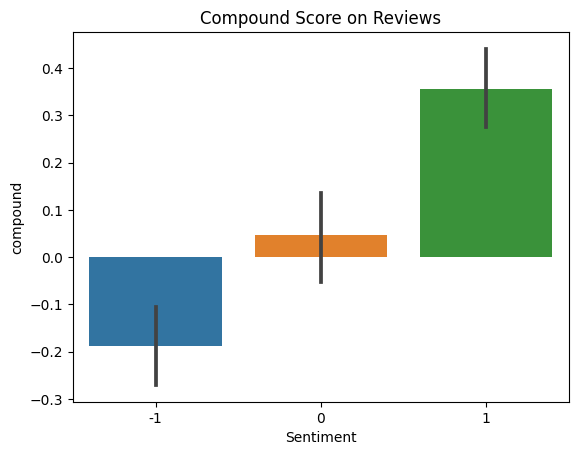

In [ ]:
ax = sns.barplot(data=vaders, x="Sentiment", y="compound")
ax.set_title("Compound Score on Reviews")

## BERT

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
sentence = "This is a very good day to learn some cool coding stuff"
encoded_text = tokenizer(sentence, return_tensors='pt')
output = model(**encoded_text)
#the highest value represents what position represents the actual sentiment
scores = torch.argmax(output.logits).item()+1
scores

tensor([0.0041, 0.0064, 0.0693, 0.5204, 0.3998], grad_fn=<SoftmaxBackward0>) 3


In [ ]:
res = {}
for index, row in df.iterrows():
  text = row['Text']
  encoded_text = tokenizer(text, return_tensors='pt')
  output = model(**encoded_text)
  scores = torch.argmax(output.logits).item()+1
  res[index] = [{"label":scores}]

In [ ]:
df1 = pd.DataFrame(res).T
df1['Index'] = df1.index
bert = df.merge(df1, how="left")
bert.head()

##DistilBERT

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentence = "This is a very good day to learn some cool coding stuff"
encoded_text = tokenizer(sentence, return_tensors='pt')
output = model(**encoded_text)
#the highest value represents what position represents the actual sentiment
scores = torch.argmax(output.logits).item()+1
scores

1

In [ ]:
res = {}
for index, row in df.iterrows():
  text = row['Text']
  encoded_text = tokenizer(text, return_tensors='pt')
  output = model(**encoded_text)
  scores = torch.argmax(output.logits).item()+1
  res[index] = [{"label":scores}]

In [ ]:
df1 = pd.DataFrame(res).T
df1['Index'] = df1.index
bert = df.merge(df1, how="left")
bert.head()

## Exploring NLTK

In [ ]:
sentence = df['Text'][111]
sentence

"I have been drinking this tea for a long time now.  I used to have to purchase it at a doctor's office because it wasn't available elsewhere.  I'm so glad that I can buy it now from Amazon.com.  I drink this tea throughout the day like other folks drink coffee.  Wonderful taste."

In [ ]:
#Word Tokenize
sentence = "This is a very good day to learn some cool coding stuff"
tokens = nltk.word_tokenize(sentence)
tokens

['This', 'is', 'a', 'very', 'good', 'day', 'to', 'learn', 'some', 'cool', 'coding', 'stuff']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Sentence Tokenization
tokens = nltk.sent_tokenize(sentence)
tokens

['I have been drinking this tea for a long time now.',
 "I used to have to purchase it at a doctor's office because it wasn't available elsewhere.",
 "I'm so glad that I can buy it now from Amazon.com.",
 'I drink this tea throughout the day like other folks drink coffee.',
 'Wonderful taste.']

In [ ]:
#Part-of-Speech Tagging
nltk.download('averaged_perceptron_tagger')
pos_tags = nltk.pos_tag(tokens)
pos_tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('day', 'NN'),
 ('to', 'TO'),
 ('learn', 'VB'),
 ('some', 'DT'),
 ('cool', 'JJ'),
 ('coding', 'NN'),
 ('stuff', 'NN')]

In [ ]:
#Named Entity Recognition (NER):
nltk.download('maxent_ne_chunker')
nltk.download('words')
chunks = nltk.ne_chunk(pos_tags)
print(chunks)

(S
  This/DT
  is/VBZ
  a/DT
  very/RB
  good/JJ
  day/NN
  to/TO
  learn/VB
  some/DT
  cool/JJ
  coding/NN
  stuff/NN)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Bag Of Words

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
temp =[]
allwords=''
for i in range(len(df)):
  try:
    text = df['Text'][i]
  except KeyError:
    pass
  text = re.sub('[^a-zA-Z0-9]', ' ', text)
  text = text.lower()
  text = text.split()
  ps = PorterStemmer()
  stopword = stopwords.words('english')
  text = [ps.stem(word) for word in text if word not in set(stopword)]
  text = ' '.join(text)
  temp.append(text)
  allwords+=text+' '
X = temp
y = df.iloc[:,0].values

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
y=y.astype('int')

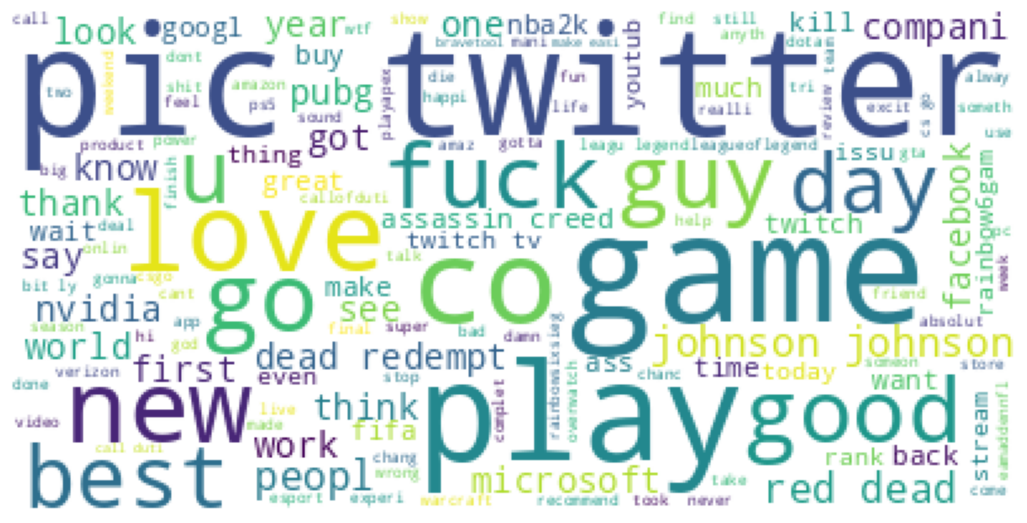

In [ ]:
from wordcloud import WordCloud,STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(allwords)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
# Bag of Words Model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500, binary=True)
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

In [ ]:
!pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_cv, X_test_cv, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:30<00:00,  1.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 12
[LightGBM] [Info] Start training from score -1.155231
[LightGBM] [Info] Start training from score -1.117131
[LightGBM] [Info] Start training from score -1.027786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

## Scraping

In [ ]:
!pip install beautifulsoup4

In [ ]:
import requests, re
from bs4 import BeautifulSoup
r = requests.get('https://www.yelp.com/biz/mejico-sydney-2')
soup = BeautifulSoup(r.text, "html.parser")
regex = re.compile(".*comment.*")
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [ ]:
df2 = pd.DataFrame(np.array(reviews), columns=['reviews'])
df2.head()

,reviews
0,Hotter than I imagine myself to be and firing ...
1,The food and service here was really good. It...
2,Visiting from Texas and decided to give this r...
3,"Great atmosphere, attentive service, solid mar..."
4,Don't come here expecting legit Mexican food b...
